In [1]:
import os
import utils
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
from glob import glob
from datetime import datetime
import tensorflow as tf
import keras
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.linear_model import LinearRegression
from fireTS.models import NARX
seed_value = 2022
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

In [2]:
lob_data=utils.caricaLOB('msft',0.1)
ld=lob_data.values.tolist()
of=utils.OF_1(ld)
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(of, columns=bCols)
m=pd.DataFrame(utils.midPrice(lob_data),columns=['m'])
m['r']=m['m'].diff().fillna(0).copy()
ret=utils.preparaRitorni(m,'msft')
of = pd.concat([of_data[-len(ret):], ret], axis=1)

In [3]:
dt=utils.deltaT(m['r'])
hk=utils.doHk(dt,11)
hk

array([  0.,  44.,  89., 133., 178., 223., 267., 312., 356., 401., 446.])

In [4]:
V = int(len(of)*0.6)
T = int(len(of)*0.8)

n_train     = of.iloc[ :V].copy()
n_vali      = of.iloc[V:T].copy()
n_test      = of.iloc[T: ].copy()

n_train = n_train.apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_vali  = n_vali .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_test  = n_test .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)

x_vars = of.columns#[:-10]

# Normalize Features
# Dividing by the standard deviation estimated using the training set
for x_var in x_vars:
    sd = n_train[x_var].std()
    n_train[x_var] = n_train[x_var] / sd
    n_vali [x_var] = n_vali [x_var] / sd
    n_test [x_var] = n_test [x_var] / sd

trainX,trainY = utils.prepXY  (n_train, typo = 'cnnlstm')    
valiX ,valiY  = utils.prepXY  (n_vali , typo = 'cnnlstm')    
testX ,testY  = utils.prepXY  (n_test , typo = 'cnnlstm')   


print(trainX.shape ,trainY.shape)
print(valiX.shape  ,valiY .shape)
print(testX.shape  ,testY .shape)

(62787, 100, 6, 1) (62787, 10)
(20863, 100, 6, 1) (20863, 10)
(20863, 100, 6, 1) (20863, 10)


In [5]:
#architettura della rete
def create_nn(T, NF,number_of_lstm):

    input_lmd = tf.keras.Input(shape=(T, NF, 1))

    conv_first1 = Conv2D(32, kernel_size=(1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #
    layer_x = layers.Conv2D(filters=16, kernel_size=(10,1),strides=(1,10), padding='same')(conv_first1)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    # inception
    convsecond_1 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', strides=(1,1))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', strides=(1,1))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(layer_x)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.3, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    #  LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)
    # output layer
    out = Dense(10, activation='leaky_relu')(conv_lstm) #prova a mettere TY=number of steps in the output
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='mse')#, metrics=['accuracy']

    return model
  
deeplob = create_nn(100, 6, 64)
checkpoint_filepath = './model_tensorflow2/weights'

callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)
saving = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#deeplob.summary()

In [6]:
#simple=deeplob.load_weights('modelMSFT.h5')
simple=deeplob.fit(trainX, trainY, validation_data=(valiX, valiY),  epochs=50, batch_size=256,callbacks=[callback,saving])


Epoch 1/50
246/246 [==============================] - 127s 506ms/step - loss: 0.7252 - val_loss: 0.4796
Epoch 2/50
246/246 [==============================] - 128s 520ms/step - loss: 0.4550 - val_loss: 0.3918
Epoch 3/50
246/246 [==============================] - 147s 600ms/step - loss: 0.3922 - val_loss: 0.3509
Epoch 4/50
246/246 [==============================] - 165s 670ms/step - loss: 0.3623 - val_loss: 0.3329
Epoch 5/50
246/246 [==============================] - 238s 968ms/step - loss: 0.3443 - val_loss: 0.3188
Epoch 6/50
246/246 [==============================] - 186s 756ms/step - loss: 0.3314 - val_loss: 0.3046
Epoch 7/50
246/246 [==============================] - 189s 768ms/step - loss: 0.3209 - val_loss: 0.2950
Epoch 8/50
246/246 [==============================] - 189s 769ms/step - loss: 0.3112 - val_loss: 0.2937
Epoch 9/50
246/246 [==============================] - 185s 754ms/step - loss: 0.3043 - val_loss: 0.2831
Epoch 10/50
246/246 [==============================] - 194s 791m

In [7]:
#deeplob.save('modelMSFT.h5')

In [ ]:
loss=simple.history['loss']
lossVal=simple.history['val_loss']
lossVal

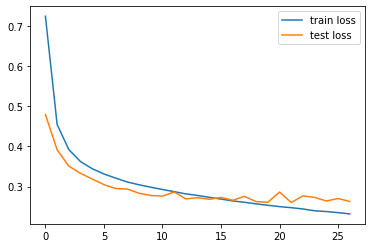

In [9]:
plt.plot(simple.history['loss'], label='train loss')
plt.plot(simple.history['val_loss'], label='test loss')
plt.legend()
plt.show()

In [10]:
Ptrain= deeplob.predict(trainX)
Ptest = deeplob.predict(testX)

652/652 [==============================] - 32s 50ms/step


In [11]:
r2os = np.zeros(10)
for i in range(10):
    r2os[i]=1-mse(y_pred=Ptest[:,i],y_true=testY[:,i])/mse(y_pred=[np.mean(trainY[:,i])]*len(testY),y_true=testY[:,i])
r2os

array([0.20681875, 0.21743389, 0.23408731, 0.24878044, 0.25755401,
       0.26920821, 0.27345499, 0.28449956, 0.28966231, 0.29158119])

In [12]:
r2is = np.zeros(10)
for i in range(10):
    r2is[i]=1-mse(y_pred=Ptrain[:,i],y_true=trainY[:,i])/mse(y_pred=[np.mean(trainY[:,i])]*len(trainY),y_true=trainY[:,i])
r2is

array([0.65122799, 0.69994896, 0.75218611, 0.77160602, 0.78901225,
       0.80134438, 0.8091013 , 0.81456902, 0.81691782, 0.81172888])

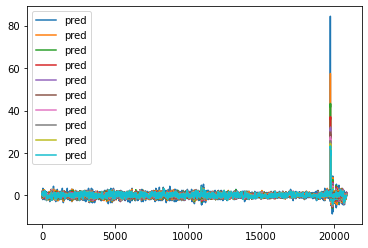

In [13]:
plt.plot(testY)
plt.plot(Ptest,label='pred')
plt.legend();

c:\Users\macri\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


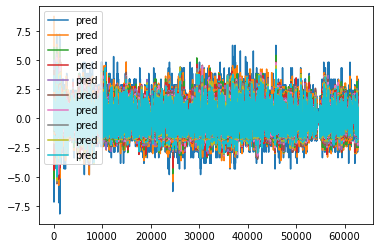

In [14]:
plt.plot(trainY)
plt.plot(Ptrain,label='pred')
plt.legend();

In [15]:
r2_score(y_pred=Ptest,y_true=testY), r2_score(y_pred=Ptrain,y_true=trainY)

(0.2550076608210122, 0.7717642721840912)

In [16]:
x = n_train.iloc[:,:6]
y = n_train.iloc[:,6:]

yfor =np.empty((len(valiY),10))

for i in range(10):
    mdl = NARX(LinearRegression(), auto_order=1, exog_order=[100,100,100,100,100,100])
    mdl.fit(x,y.iloc[:,i])
    yfor[:,i] = mdl.forecast(x,y.iloc[:,i],step=len(valiY))

In [17]:
r2ARXos = np.zeros(10)
for i in range(10):
    r2ARXos[i]=1-mse(y_pred=yfor[:,i],y_true=valiY[:,i])/mse(y_pred=[np.mean(trainY[:,i])]*len(valiY),y_true=valiY[:,i])
r2ARXos

array([-0.00327482, -0.00682558, -0.01146984, -0.01324398, -0.01666674,
       -0.02096704, -0.02678997, -0.0317435 , -0.03724015, -0.05112148])

In [18]:
r2_score(y,n_train.iloc[:,-10:]),  r2_score(yfor,valiY)

(1.0, -2018.871017941862)

In [19]:
r2ARXis = np.zeros(10)
for i in range(10):
    r2ARXis[i]=1-mse(y_pred=y.iloc[:,i],y_true=n_train.iloc[:,-10+i])/mse(y_pred=[np.mean(n_train.iloc[:,-10+i])]*len(n_train.iloc[:,-10+i]),y_true=n_train.iloc[:,-10+i])
r2ARXis

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])